# Evaluation trained discrete model of a Lagrangian density on coarse mesh
## (Reference: discrete wave equation on a finer mesh)

## Loading / initialisation / analysis of training procedure

In [1]:
# load packages
using JSON
using Random
using DelimitedFiles

# load tools
include("7ptStencilFun.jl")
include("plotting_tools.jl")
include("LdNetworkArchitecture.jl")

# load model and latest update to parameters
parameter_data=JSON.parsefile("4590_2023-07-31_08-40-43run_param_data.json");
paramsVec=Float64.(parameter_data["learned_parameters"]);
training_losses1 = readdlm("losses1.txt");
training_losses2 = readdlm("losses2.txt");
training_losses = [training_losses1;training_losses2];
no_epochs = size(training_losses,1)*10

6380

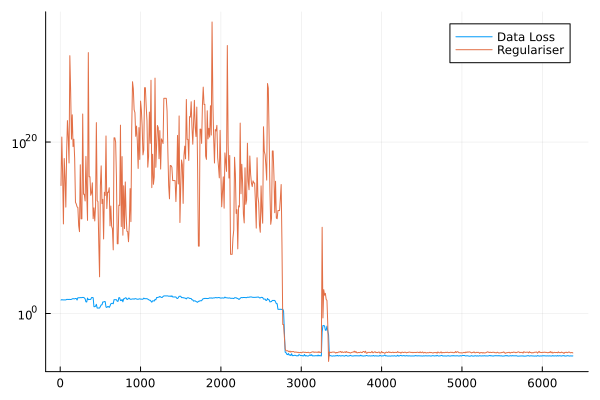

In [2]:
pLosses=plot(10:10:no_epochs,training_losses,yaxis=:log10,label=["Data Loss" "Regulariser"])

In [3]:
#savefig(pLosses,"pics/losses.pdf")

In [4]:
# details of two consecutive training sessions
println("final loss / regulariser "*string(training_losses[end,:])*"\n")
print("last saved epoch "*string((1790+4590)*10))

final loss / regulariser [1.1282530449446652e-5, 2.4702716853207994e-5]

last saved epoch 63800

## reference model on fine mesh

In [5]:
## time-spacial domain
l = 1. # length of spatial domain including (periodic) boundary
T = .5 # final time

# discretisation parameters reference model
MRef = 20 # spatial grid points 
NRef = 20 # time steps
dxRef = l/MRef # periodic boundary conditions
dtRef = T/NRef
XMeshRef   = 0:dxRef:(MRef-1)*dxRef # periodic mesh
XMeshbdRef = 0:dxRef:MRef*dxRef # periodic mesh
TMeshRef = 0:dtRef:NRef*dtRef       

# Lagrangian 
Potential_ref(u) = 1/2  * u^2
Lagrangian_ref(u,ut,ux) = 1/2*ut^2-1/2*ux^2-Potential_ref(u)
Ld_ref(u,udown,uleft) = Lagrangian_ref(u,(u-udown)/dtRef,(u-uleft)/dxRef)
Ld_ref(x0) = Ld_ref(x0[1],x0[2],x0[3])
Lagrangian_ref_d(u,udown,uleft) = Lagrangian_ref(u,(u-udown)/dtRef,(u-uleft)/dxRef)
function Lagrangian_ref(uJet1);    u,ut,ux = uJet1;    return Lagrangian_ref(u,ut,ux); end
function Lagrangian_ref_d(uCollect);    u,udown,uleft = uCollect;    return Lagrangian_ref_d(u,udown,uleft); end

Lagrangian_ref_d (generic function with 2 methods)

## initialise trained model of Ld

In [6]:
# mesh learned model
M = 10 # spatial grid points 
N = 10 # time steps
dx = l/M # periodic boundary conditions
dt = T/N
XMesh   = 0:dx:(M-1)*dx # periodic mesh
XMeshbd = 0:dx:M*dx # periodic mesh
TMesh = 0:dt:N*dt

0.0:0.05:0.5

In [7]:
LdArchitecture, _ = InitLd(MersenneTwister(1234); NNwidth=10, sigma = tanh);

In [8]:
# periodic spatial indices
modInd(i::Int) = mod(i-1,M)+1

# define learned functions from learned model
learned_Ld(z) = LdArchitecture(paramsVec,z)
Learned_Ld(u,uup,uright) = LdArchitecture(paramsVec,[u; uup; uright])

Learned_Ld (generic function with 1 method)

In [9]:
TrainingData = JSON.parsefile("training_data.json")
converter  = x-> hcat(x...)
converter2 = x -> converter.(x)
training_data = converter2(TrainingData["training_dataU"]);
length(training_data), size(training_data[1])

(80, (21, 20))

In [10]:
# function for plotting
plotU, contourU,contourU! = InstantiatePlotFun(dt,dx)

(plotU, contourU, contourU!)

## Model evaluation
### Extrapolation, unseen initial data

In [11]:
## reference
u0_refMesh = sin.(2*pi/l*XMeshRef)
u1_refMesh = sin.(2*pi/l*XMeshRef)
extrapolation_factor=20
U_unseen_ref_RefMesh=PDEContinue(Lagrangian_ref_d, u0_refMesh, u1_refMesh; time_steps = extrapolation_factor*NRef);

In [12]:
U_unseen_ref = U_unseen_ref_RefMesh[1:2:end,1:2:end];

In [13]:
u0 = u0_refMesh[1:2:MRef]
u1 = u1_refMesh[1:2:MRef]
U_unseen = PDEContinue(Learned_Ld, u0, u1; time_steps=extrapolation_factor*N);

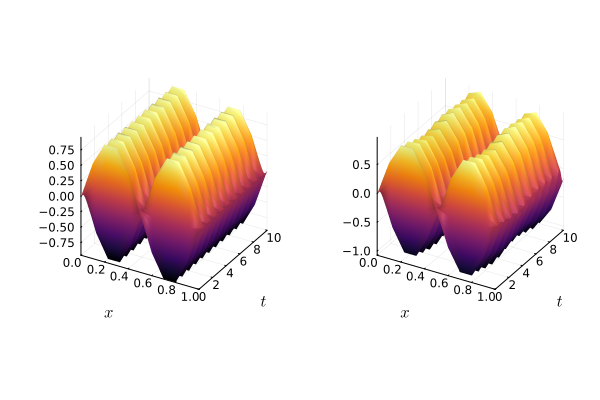

In [14]:
plot(plotU(U_unseen_ref),plotU(U_unseen))

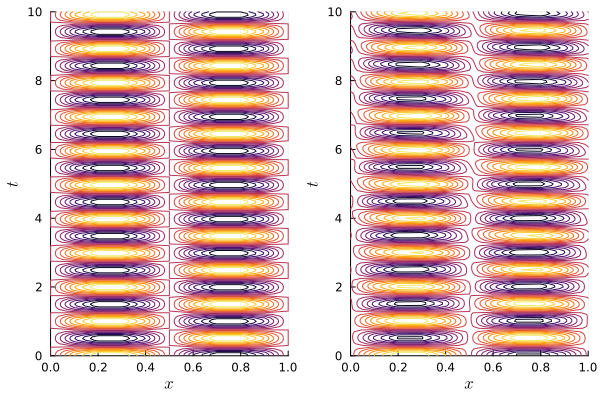

In [15]:
plot(contourU(U_unseen_ref),contourU(U_unseen))

In [16]:
# error
println(string(maximum(abs.(U_unseen-U_unseen_ref)))*" inf error")
println(string(sqrt(sum((U_unseen-U_unseen_ref).^2)*(dx*dt))/(extrapolation_factor*T*l))*" l2 error (normalised by domain size)")  # l2 error normalised by domain size

0.3290312590898893 inf error
0.036725612959727275 l2 error (normalised by domain size)


In [17]:
## save plots
#=
pU_unseen_ref=plotU(U_unseen_ref)
pU_unseen_ref=plot!(size=(300,200),dpi=600,xticks=3,yticks=3)
savefig(pU_unseen_ref,"pics/U_unseen_ref.png")
pU_unseen=plotU(U_unseen)
pU_unseen=plot!(size=(300,200),dpi=600,xticks=3,yticks=3)
savefig(pU_unseen,"pics/U_unseenML.png")

cU_unseen_ref=contourU(U_unseen_ref)
cU_unseen_ref=plot!(size=(300,200),dpi=600,xticks=3,yticks=3)
savefig(cU_unseen_ref,"pics/U_unseen_ref_contour.pdf")
cU_unseen=contourU(U_unseen)
cU_unseen=plot!(size=(300,200),dpi=600,xticks=3,yticks=3)
savefig(cU_unseen,"pics/U_unseenML_contour.pdf")
=#

### Travelling Waves as initial values

In [18]:
wave_no = 1
kappa = 2*pi*wave_no/l

lattice_eq_rhs = 1+ dtRef^2/dxRef^2*(cos(kappa*dxRef)-1) - dtRef^2/2

if abs(lattice_eq_rhs)>1
    print("The discretised PDE does not admit real valued travelling wave with this wave number for this potential/dx/dt. Discriminant ")
    print(lattice_eq_rhs)
end

c_tw_discrete=acos(lattice_eq_rhs)/(kappa*dtRef)

amplitude_discrete = [1.,0.]
tw_discrete(t,x) = amplitude_discrete[1]*sin(kappa*(x-c_tw_discrete*t))+amplitude_discrete[2]*cos(kappa*(x-c_tw_discrete*t))
U_tw_discreteMeshRef = tw_discrete.(TMeshRef,transpose(XMeshRef))
U_tw_discrete_ref = U_tw_discreteMeshRef[1:2:end,1:2:end];

print("consistency with DEL: "); print(maximum(abs.(DELTest(Lagrangian_ref_d,U_tw_discreteMeshRef))))

consistency with DEL: 2.2168933355715126e-12

In [19]:
u0TW=U_tw_discrete_ref[1,:]
u1TW=U_tw_discrete_ref[2,:]

U_tw_discrete = PDEContinue(Learned_Ld, u0TW, u1TW; time_steps=N);
println("Consistency of computed TW with DEL(Learned_Ld): "*string(maximum(abs.(DELTest(Learned_Ld,U_tw_discrete)))))
println("Consistency of reference TW with DEL(Learned_Ld): "*string(maximum(abs.(DELTest(Learned_Ld,U_tw_discrete_ref)))))

Consistency of computed TW with DEL(Learned_Ld): 0.3394168439825749
Consistency of reference TW with DEL(Learned_Ld): 0.07337288799882402


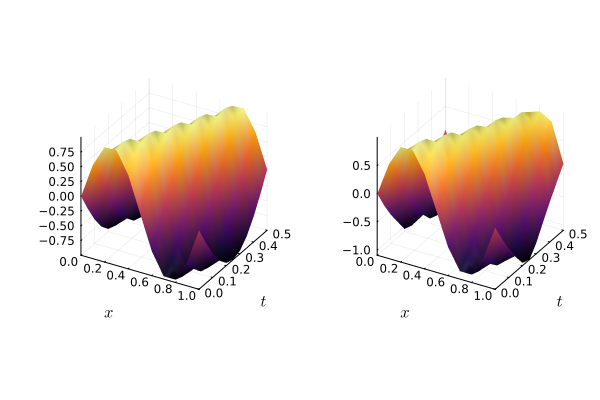

In [20]:
plot(plot(plotU(U_tw_discrete_ref)),plotU(U_tw_discrete))

In [21]:
# error
println(string(maximum(abs.(U_tw_discrete_ref-U_tw_discrete)))*" inf error")
println(string(sqrt(sum((U_tw_discrete_ref-U_tw_discrete).^2)*(dx*dt))/(T*l))*" l2 error (normalised by domain size)")  # l2 error normalised by domain size

0.23867026121415336 inf error
0.10909719232043308 l2 error (normalised by domain size)


In [22]:
## save plots
#=
pU_tw_discrete_ref=plotU(U_tw_discrete_ref)
pU_tw_discrete_ref=plot!(size=(300,200),dpi=600,xticks=3,yticks=3)
savefig(pU_tw_discrete_ref,"pics/U_tw_discrete_ref.png")
pU_tw_discreteML=plotU(U_tw_discrete)
pU_tw_discreteML=plot!(size=(300,200),dpi=600,xticks=3,yticks=3)
savefig(pU_tw_discreteML,"pics/U_tw_discreteML.png")

cU_tw_discrete_ref=contourU(U_tw_discrete_ref)
cU_tw_discrete_ref=plot!(size=(300,200),dpi=600,xticks=3,yticks=3)
savefig(cU_tw_discrete_ref,"pics/U_tw_discrete_ref_contour.pdf")
cU_tw_discrete_ML=contourU(U_tw_discrete)
cU_tw_discrete_ML=plot!(size=(300,200),dpi=600,xticks=3,yticks=3)
savefig(cU_tw_discrete_ML,"pics/U_tw_discrete_ML_contour.pdf")
=#
